<a href="https://colab.research.google.com/github/RabisaMushtaq/Recommendation_system/blob/master/BigData_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Set Up Your PySpark Environment

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("ProductRecommendationALS") \
    .getOrCreate()


## Step 2: Load the Dataset

In [ ]:
# Load CSV file
file_path = "/content/customer_spending_1M_2018_2025.csv"
df = spark.read.option("header", True).option("inferSchema", True).csv(file_path)

df.show()
df.printSchema()


+--------------+-------------------+------+---+--------------+--------------+--------+----------------+--------------+--------+------------+
|Transaction_ID|   Transaction_date|Gender|Age|Marital_status|   State_names| Segment|Employees_status|Payment_method|Referral|Amount_spent|
+--------------+-------------------+------+---+--------------+--------------+--------+----------------+--------------+--------+------------+
|          1000|2018-01-01 00:04:00|Female| 39|        Single|      Oklahoma|Platinum|    Unemployment|          Card|       0|      1557.5|
|          1001|2018-01-01 00:06:00|  Male| 34|       Married|        Hawaii|   Basic|         workers|        PayPal|       1|      153.55|
|          1002|2018-01-01 00:14:00|Female| 53|       Married|          Iowa|   Basic|   self-employed|        PayPal|       1|     2640.96|
|          1003|2018-01-01 00:23:00|  Male| 33|       Married|     Wisconsin|   Basic|   self-employed|          Card|       1|      293.58|
|          10

##  Step 3: Data Cleaning

In [ ]:

from pyspark.sql.functions import monotonically_increasing_id

# Drop nulls and duplicates
df_cleaned = df.dropna().dropDuplicates()

# Assign fake CustomerID and ProductID for ALS (since they're missing)
# Create a fake 'CustomerID' by combining attributes like Gender, Age, State
df_customers = df_cleaned.select("Gender", "Age", "State_names").dropDuplicates() \
    .withColumn("CustomerID", monotonically_increasing_id())

# Create a fake 'ProductID' by combining Segment and Payment method (simulate product category)
df_products = df_cleaned.select("Segment", "Payment_method").dropDuplicates() \
    .withColumn("ProductID", monotonically_increasing_id())

# Join back to main data
df1 = df_cleaned.join(df_customers, on=["Gender", "Age", "State_names"], how="left")
df2 = df1.join(df_products, on=["Segment", "Payment_method"], how="left")

# Rename amount spent as rating
df_final = df2.select("CustomerID", "ProductID", "Amount_spent").withColumnRenamed("Amount_spent", "rating")

df_final.show()


+----------+---------+-------+
|CustomerID|ProductID| rating|
+----------+---------+-------+
|         5|        6|1611.28|
|        89|       11| 395.99|
|       136|        4| 153.55|
|       146|        2| 841.26|
|       194|        3| 713.87|
|       213|       11| 567.74|
|       379|       10| 969.93|
|       485|        2|2659.77|
|       587|        4|1581.77|
|       591|        6| 858.76|
|       667|        1| 599.19|
|       698|        6| 536.85|
|       798|       12|2580.54|
|       849|        4| 701.22|
|       971|        2|2904.41|
|      1295|        1|2767.44|
|      1330|        8| 2476.4|
|      1369|        8| 1922.8|
|      1430|       10| 221.17|
|      1457|        8| 1787.8|
+----------+---------+-------+
only showing top 20 rows



##Step 4: Big Data-Based Filtering — User/Product Pruning for ALS

In [ ]:
from pyspark.sql.functions import count
# Step 4: Filter to frequent users and frequent products
from pyspark.sql.functions import col

# Count interactions per CustomerID and ProductID
user_counts = df_final.groupBy("CustomerID").count().withColumnRenamed("count", "user_count")
product_counts = df_final.groupBy("ProductID").count().withColumnRenamed("count", "product_count")

# Filter based on threshold
frequent_users = user_counts.filter(col("user_count") >= 10).select("CustomerID")
frequent_products = product_counts.filter(col("product_count") >= 10).select("ProductID")

df_filtered = df_final.join(frequent_users, on="CustomerID") \
                      .join(frequent_products, on="ProductID")

print("Filtered users:", df_filtered.select("CustomerID").distinct().count())
print("Filtered products:", df_filtered.select("ProductID").distinct().count())

# Show how many interactions remain
print("Filtered data size:", df_filtered.count())


Filtered users: 1720
Filtered products: 15
Filtered data size: 804874


In [ ]:
df_filtered.groupBy("CustomerID").count().orderBy("count", ascending=False).show()
df_filtered.groupBy("ProductID").count().orderBy("count", ascending=False).show()

+----------+-----+
|CustomerID|count|
+----------+-----+
|8589934943| 1581|
|       311| 1268|
|8589934927| 1242|
|8589935308| 1242|
|8589935186| 1241|
|       676| 1241|
|8589934627| 1238|
|       758| 1230|
|       482| 1215|
|8589934773| 1213|
|8589934849| 1213|
|8589935081| 1207|
|8589934904| 1205|
|         2| 1196|
|8589935054| 1190|
|8589935333| 1190|
|8589934832| 1190|
|       512| 1186|
|       371| 1182|
|8589935457| 1175|
+----------+-----+
only showing top 20 rows

+---------+------+
|ProductID| count|
+---------+------+
|        4|168665|
|        8|108466|
|        6| 95049|
|       14| 79933|
|        9| 63094|
|       10| 42517|
|        2| 41761|
|       11| 35312|
|        5| 34924|
|        7| 34189|
|        1| 30217|
|       13| 24790|
|        3| 22802|
|        0| 19179|
|       12| 13067|
+---------+------+



## Step 5: Prepare Data for ALS

In [ ]:
from pyspark.sql.functions import sum
from pyspark.ml.feature import StringIndexer

# Step 1: Aggregate duplicate user-product pairs by summing their ratings
df_for_als = df_final.groupBy("CustomerID", "ProductID") \
                     .agg(sum("rating").alias("rating"))

# Step 2: Convert string IDs to numeric IDs for ALS
user_indexer = StringIndexer(inputCol="CustomerID", outputCol="userId")
item_indexer = StringIndexer(inputCol="ProductID", outputCol="itemId")

# Step 3: Apply the indexers
df_indexed = user_indexer.fit(df_for_als).transform(df_for_als)
df_indexed = item_indexer.fit(df_indexed).transform(df_indexed)

# Step 4: View final data ready for ALS
df_indexed.select("userId", "itemId", "rating").show()


# Check how many distinct products each user has rated
df_indexed.groupBy("userId").count().show()

# Check how many distinct users have rated each product
df_indexed.groupBy("itemId").count().show()

+------+------+------------------+
|userId|itemId|            rating|
+------+------+------------------+
|1085.0|  10.0|1004507.8400000024|
|1155.0|   0.0| 670451.0999999975|
|1460.0|   9.0|          18839.75|
|1542.0|  14.0|1016732.7599999966|
|1649.0|   9.0|         305171.75|
| 508.0|   2.0| 1148099.090000003|
| 735.0|   0.0|  53116.3999999999|
|  83.0|   4.0| 761877.5999999979|
| 785.0|   0.0|164026.70999999985|
|  89.0|   1.0| 712496.3199999965|
|  10.0|   0.0|124281.67999999951|
| 700.0|   4.0| 887307.7500000033|
| 106.0|   2.0| 1046261.999999996|
|1046.0|  12.0| 623870.4800000003|
|1057.0|   0.0| 408770.9500000011|
|1270.0|   8.0|1108114.3399999943|
|1727.0|   1.0| 546567.4399999987|
| 300.0|   0.0| 576591.4599999986|
| 370.0|   3.0|1110405.5599999987|
| 655.0|   0.0| 299248.9500000001|
+------+------+------------------+
only showing top 20 rows

+------+-----+
|userId|count|
+------+-----+
|1051.0|    1|
| 299.0|    1|
| 934.0|    1|
| 305.0|    1|
| 596.0|    1|
| 558.0|    1|

In [ ]:
# Check how many distinct products each user has rated
df_indexed.groupBy("userId").count().show()

# Check how many distinct users have rated each product
df_indexed.groupBy("itemId").count().show()

+------+-----+
|userId|count|
+------+-----+
|1051.0|    1|
| 299.0|    1|
| 934.0|    1|
| 305.0|    1|
| 596.0|    1|
| 558.0|    1|
| 692.0|    1|
| 769.0|    1|
| 496.0|    1|
| 782.0|    1|
| 184.0|    2|
| 170.0|    2|
| 576.0|    1|
|1369.0|    1|
| 147.0|    2|
| 810.0|    1|
|1587.0|    1|
| 720.0|    1|
| 735.0|    1|
| 608.0|    1|
+------+-----+
only showing top 20 rows

+------+-----+
|itemId|count|
+------+-----+
|   8.0|   85|
|   0.0|  409|
|   7.0|   88|
|   1.0|  261|
|   4.0|  155|
|  11.0|   61|
|  14.0|   33|
|   3.0|  198|
|   2.0|  231|
|  10.0|   75|
|  13.0|   47|
|   6.0|  104|
|   5.0|  106|
|   9.0|   84|
|  12.0|   56|
+------+-----+



## Step 6: Train the ALS Model



In [ ]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Split into training and test sets
(training, test) = df_indexed.randomSplit([0.8, 0.2])

# Train ALS model
als = ALS(
    maxIter=20,
    regParam=0.01,
    userCol="userId",
    itemCol="itemId",
    ratingCol="rating",
    coldStartStrategy="drop",  # handle NaNs
    implicitPrefs=True
)

model = als.fit(training)


##  Step 7: Evaluate the Model

In [ ]:
# Predict on test set
predictions = model.transform(test)

# Evaluate using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)

print(f"Root-mean-square error = {rmse}")


Root-mean-square error = 639277.9661975233


##Step 8: Reverse Indexing for Decoding

In [21]:
from pyspark.ml.feature import StringIndexer
user_indexer = StringIndexer(inputCol="CustomerID", outputCol="userId")
item_indexer = StringIndexer(inputCol="ProductID", outputCol="itemId")

user_indexed_model = user_indexer.fit(df_for_als)
item_indexed_model = item_indexer.fit(df_for_als)

df_indexed = user_indexed_model.transform(df_for_als)
df_indexed = item_indexed_model.transform(df_indexed)

from pyspark.ml.feature import IndexToString

user_reverse = IndexToString(inputCol="userId", outputCol="CustomerID_decoded",
                              labels=user_indexed_model.labels)
item_reverse = IndexToString(inputCol="itemId", outputCol="ProductID_decoded",
                              labels=item_indexed_model.labels)


## Step 9: Generate Top-N Recommendations

**Recommend top 10 users for each product**

In [22]:
item_recommendations = model.recommendForAllItems(10)
item_recommendations.show(truncate=False)


+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|itemId|recommendations                                                                                                                                                                               |
+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|10    |[{93, 0.99999994}, {840, 0.9999999}, {79, 0.9999999}, {56, 0.9999999}, {1622, 0.9999998}, {1479, 0.9999998}, {1439, 0.9999998}, {1308, 0.9999998}, {1128, 0.9999998}, {1077, 0.9999998}]      |
|0     |[{598, 0.9999966}, {569, 0.9999966}, {1640, 0.99999404}, {962, 0.99999404}, {727, 0.9999939}, {484, 0.9999939}, {1464, 0.9999938}, {1428, 0.9999938}, {1643, 0.9999937}, {1555, 0.9999937}]   |


**Recommend top 10 products for each user**

In [23]:
user_recommendations = model.recommendForAllUsers(10)
user_recommendations.show(truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                  |
+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0     |[{4, 1.736802}, {3, 1.3278042}, {11, 1.026103}, {7, 0.9999985}, {0, 0.9999897}, {8, 0.80345577}, {2, 0.33901367}, {1, 0.10981738}, {10, -0.074548885}, {6, -0.19319917}]         |
|1     |[{4, 1.9455786}, {3, 1.0000033}, {0, 0.999992}, {11, 0.92424846}, {8, 0.7873459}, {2, 0.14884572}, {6, 0.05107507}, {10, -0.010312951}, {1, -0.07915065}, {7, -0.13583252}]      |
|2     |[{3, 1.5742285}, {11, 1.3674403}, {4, 1.0000024}, {2, 1.0

## Step 10: Insights & Visualizations




In [24]:
# Top most active users
df_indexed.groupBy("userId").count().orderBy("count", ascending=False).show()

# Top selling products
df_indexed.groupBy("itemId").sum("rating").orderBy("sum(rating)", ascending=False).show()


+------+-----+
|userId|count|
+------+-----+
|   8.0|    3|
|   0.0|    3|
|   7.0|    3|
|  18.0|    3|
|   1.0|    3|
|   4.0|    3|
|  11.0|    3|
|  14.0|    3|
|  19.0|    3|
|   3.0|    3|
|   2.0|    3|
|  17.0|    3|
|  10.0|    3|
|  13.0|    3|
|   6.0|    3|
|  20.0|    3|
|  15.0|    3|
|   5.0|    3|
|   9.0|    3|
|  16.0|    3|
+------+-----+
only showing top 20 rows

+------+--------------------+
|itemId|         sum(rating)|
+------+--------------------+
|   0.0|2.3535004830999997E8|
|   1.0|1.5358210823000008E8|
|   2.0|1.4431175761999997E8|
|   3.0|1.1489664418000007E8|
|   4.0| 9.045348099000005E7|
|   5.0|6.1289011140000015E7|
|   6.0| 5.928651637000002E7|
|   9.0| 5.019659488000003E7|
|   7.0| 4.991938182999997E7|
|   8.0| 4.835797516999996E7|
|  10.0|       4.417514405E7|
|  11.0|3.1827992659999993E7|
|  12.0|3.1260533880000025E7|
|  13.0|2.7627460640000008E7|
|  14.0|1.8960002410000004E7|
+------+--------------------+



In [25]:
df_final.groupBy("CustomerID") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(20)


+----------+-----+
|CustomerID|count|
+----------+-----+
|      1199| 1581|
|       311| 1268|
|      1564| 1242|
|      1183| 1242|
|       676| 1241|
|      1442| 1241|
|       883| 1238|
|       758| 1230|
|       482| 1215|
|      1029| 1213|
|      1105| 1213|
|      1337| 1207|
|      1160| 1205|
|         2| 1196|
|      1310| 1190|
|      1589| 1190|
|      1088| 1190|
|       512| 1186|
|       371| 1182|
|      1713| 1175|
+----------+-----+
only showing top 20 rows



In [26]:
# Total money spent per product
df_final.groupBy("ProductID").sum("rating").orderBy("sum(rating)", ascending=False).show()


+---------+--------------------+
|ProductID|         sum(rating)|
+---------+--------------------+
|        4|2.3535004830998766E8|
|        8| 1.535821082299888E8|
|        6|1.4431175761999512E8|
|       14|1.1489664417999157E8|
|        9| 9.045348099000138E7|
|       10| 6.128901114000216E7|
|        2| 5.928651637000117E7|
|        7|  5.01965948799983E7|
|       11|4.9919381829998866E7|
|        5| 4.835797516999872E7|
|        1| 4.417514404999983E7|
|       13|3.1827992659999866E7|
|        3|3.1260533880001895E7|
|        0|2.7627460640001252E7|
|       12|1.8960002410000257E7|
+---------+--------------------+



In [27]:
# Average rating per product (i.e., average amount spent)
df_final.groupBy("ProductID").avg("rating").orderBy("avg(rating)", ascending=False).show()


+---------+------------------+
|ProductID|       avg(rating)|
+---------+------------------+
|        6|1518.2880158654496|
|        7|1468.2089233378658|
|        1|1461.9301734123121|
|       12| 1450.983577714874|
|       10|1441.5177726556944|
|        0|1440.5057948798817|
|       14|1437.4118847033337|
|        9|1433.6304718356957|
|        2|1419.6622774838047|
|        8|1415.9470085555733|
|       11|1413.6662276279696|
|        4|1395.3698058873367|
|        5|1384.6631305119322|
|        3|1370.9557880888472|
|       13|1283.9045042355735|
+---------+------------------+



In [28]:
print("Unique customers:", df_final.select("CustomerID").distinct().count())
print("Unique products:", df_final.select("ProductID").distinct().count())


Unique customers: 1741
Unique products: 15


<Axes: title={'center': 'Top 10 Selling Products'}, xlabel='itemId'>

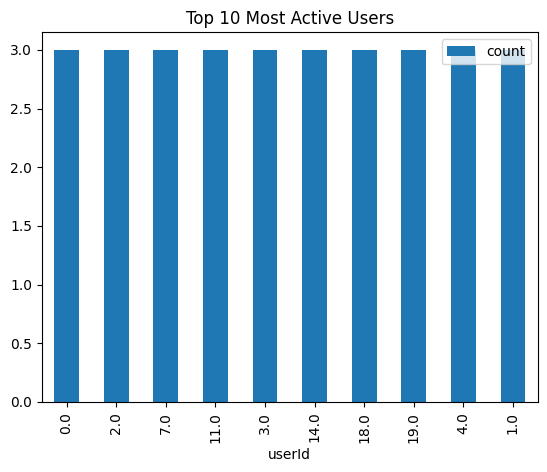

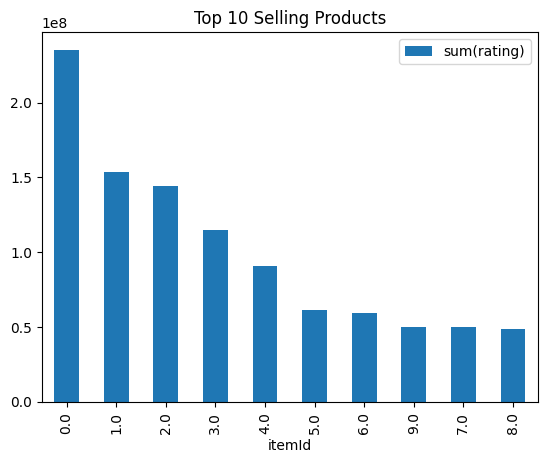

In [29]:
# For top users
top_users = df_indexed.groupBy("userId").count().orderBy("count", ascending=False).limit(10).toPandas()
top_users.plot(kind='bar', x='userId', y='count', title='Top 10 Most Active Users')

# For top products
top_items = df_indexed.groupBy("itemId").sum("rating").orderBy("sum(rating)", ascending=False).limit(10).toPandas()
top_items.plot(kind='bar', x='itemId', y='sum(rating)', title='Top 10 Selling Products')


## Step 11: Save Your Results

In [30]:
from pyspark.sql.functions import explode

# Flatten recommendations
user_recs_flat = user_recommendations.selectExpr("userId", "explode(recommendations) as rec") \
                                     .selectExpr("userId", "rec.itemId as itemId", "rec.rating as rating")

item_recs_flat = item_recommendations.selectExpr("itemId", "explode(recommendations) as rec") \
                                      .selectExpr("itemId", "rec.userId as userId", "rec.rating as rating")

# -Show for verification
user_recs_flat.show()
item_recs_flat.show()

# Save to CSV
user_recs_flat.write.csv("user_recommendations.csv", header=True, mode="overwrite")
item_recs_flat.write.csv("item_recommendations.csv", header=True, mode="overwrite")

+------+------+------------+
|userId|itemId|      rating|
+------+------+------------+
|     0|     4|    1.736802|
|     0|     3|   1.3278042|
|     0|    11|    1.026103|
|     0|     7|   0.9999985|
|     0|     0|   0.9999897|
|     0|     8|  0.80345577|
|     0|     2|  0.33901367|
|     0|     1|  0.10981738|
|     0|    10|-0.074548885|
|     0|     6| -0.19319917|
|     1|     4|   1.9455786|
|     1|     3|   1.0000033|
|     1|     0|    0.999992|
|     1|    11|  0.92424846|
|     1|     8|   0.7873459|
|     1|     2|  0.14884572|
|     1|     6|  0.05107507|
|     1|    10|-0.010312951|
|     1|     1| -0.07915065|
|     1|     7| -0.13583252|
+------+------+------------+
only showing top 20 rows

+------+------+----------+
|itemId|userId|    rating|
+------+------+----------+
|    10|    93|0.99999994|
|    10|   840| 0.9999999|
|    10|    79| 0.9999999|
|    10|    56| 0.9999999|
|    10|  1622| 0.9999998|
|    10|  1479| 0.9999998|
|    10|  1439| 0.9999998|
|    10|

In [31]:
# ----------- Decode user recommendations ------------
user_recs_decoded = user_reverse.transform(user_recs_flat)
user_recs_decoded = item_reverse.transform(user_recs_decoded)

user_recs_decoded.select("CustomerID_decoded", "ProductID_decoded", "rating").show(truncate=False)

# ----------- Decode item recommendations ------------
item_recs_decoded = user_reverse.transform(item_recs_flat)
item_recs_decoded = item_reverse.transform(item_recs_decoded)

item_recs_decoded.select("CustomerID_decoded", "ProductID_decoded", "rating").show(truncate=False)

+------------------+-----------------+------------+
|CustomerID_decoded|ProductID_decoded|rating      |
+------------------+-----------------+------------+
|1029              |9                |1.736802    |
|1029              |14               |1.3278042   |
|1029              |13               |1.026103    |
|1029              |11               |0.9999985   |
|1029              |4                |0.9999897   |
|1029              |5                |0.80345577  |
|1029              |6                |0.33901367  |
|1029              |8                |0.10981738  |
|1029              |1                |-0.074548885|
|1029              |2                |-0.19319917 |
|1088              |9                |1.9455786   |
|1088              |14               |1.0000033   |
|1088              |4                |0.999992    |
|1088              |13               |0.92424846  |
|1088              |5                |0.7873459   |
|1088              |6                |0.14884572  |
|1088       